# Load Packages for Julia

In [1]:
using DataFrames
using Distributions
using Plots

# Calculate Discrete Erlang Probabilities

The following function is to calculate the discrete truncated Erlang probability, given k and γ:

$$\begin{equation} p_i = \frac{1}{C(n^{E})} \Bigl(\sum_{j=0}^{k-1} \frac{e^{-(i-1)\gamma} \times ((i-1)\gamma)^{j}} {j!} -\sum_{j=0}^{k-1} \frac{e^{-i\gamma} \times (i\gamma)^{j}} {j!}\Bigr),\quad\text{for i=1,…,nE}. \end{equation} $$

where

$$\begin{equation} n^{E} = argmin_n\Bigl(C(n) = 1 - \sum_{j=0}^{k-1} \frac{e^{-n\gamma} \times (n\gamma)^{j}} {j!} > 0.99 \Bigr) \end{equation}$$

**N.B. The formula of pi here is slightly different from what is shown in the original paper because the latter (which is likely to be wrong) would lead to negative probabilities.**

In [7]:
#' @param k     The shape parameter of the Erlang distribution.
#' @param gamma The rate parameter of the Erlang distribution.
#' @return      A vector containing all p_i values, for i = 1 : n.
function compute_erlang_discrete_prob(k::Int64, gamma::Float64)
    n_bin = 0
    factorials = zeros(Int64, k + 1)
    factorials[1] = 1  ## factorials[1] = 0!
    for i = 1 : k
        factorials[i + 1] = factorials[i] * i  ## factorial[i + 1] = i!
    end

    one_sub_cummulative_probs = Float64[]
    cummulative_prob = 0
    while cummulative_prob <= 0.99
        n_bin = n_bin + 1
        push!(one_sub_cummulative_probs, 0)
        
        for j = 0 : (k - 1)
            one_sub_cummulative_probs[end] =
                one_sub_cummulative_probs[end] +
                (
                    exp( -n_bin * gamma )
                    * ( (n_bin * gamma) ^ j )
                    / factorials[j + 1]    ## factorials[j + 1] = j!
                )
        end
        cummulative_prob = 1 - one_sub_cummulative_probs[end]
    end
    one_sub_cummulative_probs = pushfirst!(one_sub_cummulative_probs, 1)
    
    density_prob = one_sub_cummulative_probs[1 : end - 1] - one_sub_cummulative_probs[2 : end]
    density_prob = density_prob / cummulative_prob

    return density_prob
end

compute_erlang_discrete_prob (generic function with 1 method)

The implementation above calculates discrete probabilities pi’s base on the cummulative density function of the Erlang distribution:

$$\begin{equation} p_i = CDF_{Erlang}(x = i) - CDF_{Erlang}(x = i-1) \end{equation}$$

Meanwhile, the estimates of pi’s in the original paper seems to be based on the probability density function:

$$\begin{equation} p_i = PDF_{Erlang}(x = i) \end{equation}$$

While the two methods give slightly different estimates, they do not lead to any visible differences in the results of the subsequent simulations. This implementation uses the CDF function since it leads to faster runs.

# Simulate the SEIR Dynamics

The next function is to simulate the SEIR (susceptible, exposed, infectious, recovered) dynamics of an epidemic, assuming that transmission is frequency-dependent, i.e.

$$\begin{equation} \beta = \beta_0 \frac{I(t)}{N} \end{equation}$$

where N is the population size, I(t) is the number of infectious people at time t, and β0 is the base transmission rate.

This model does not consider births and deads (i.e. N is constant).

The rates at which individuals move through the E and the I classes are assumed to follow Erlang distributions of given shapes (kE, kI) and rates (γE, γI).

In [8]:
function seir_simulation( initial_state::Dict, parameters::Dict, max_time::Int64 )
    S_1 = get(initial_state, "S", -1)
    E_1 = get(initial_state, "E", -1)
    I_1 = get(initial_state, "I", -1)
    R_1 = get(initial_state, "R", -1)    
    (S_1 != -1) || error("An initial value for S is required.") 
    (E_1 != -1) || error("An initial value for E is required.") 
    (I_1 != -1) || error("An initial value for I is required.") 
    (R_1 != -1) || error("An initial value for R is required.") 

    k_E     = get(parameters, "k_E", -1)
    gamma_E = get(parameters, "gamma_E", -1.0)
    k_I     = get(parameters, "k_I", -1)
    gamma_I = get(parameters, "gamma_I", -1.0)
    beta    = get(parameters, "beta", -1.0)
    (k_E != -1)       || error("Parameter k_E must be specified.") 
    (gamma_E != -1.0) || error("Parameter gamma_E must be specified.") 
    (k_I != -1)       || error("Parameter k_I must be specified.") 
    (gamma_I != -1.0) || error("Parameter gamma_I must be specified.") 
    (beta != -1.0)    || error("Parameter beta must be specified.")     
    
    population_size = S_1 + E_1 + I_1 + R_1    
    sim_data = DataFrame( S = Int64[], E = Int64[], I = Int64[], R = Int64[] )
    push!( sim_data, (S_1, E_1, I_1, R_1) )

    
    ## Initialise a matrix to store the states of the exposed sub-blocks over time.
    exposed_block_adm_rates = compute_erlang_discrete_prob(k_E, gamma_E)
    n_exposed_blocks = length(exposed_block_adm_rates)
    exposed_blocks = zeros(Int64, max_time, n_exposed_blocks)
    exposed_blocks[1, n_exposed_blocks] = sim_data[1, :E]

    
    ## Initialise a matrix to store the states of the infectious sub-blocks over time.
    infectious_block_adm_rates = compute_erlang_discrete_prob(k_I, gamma_I)
    n_infectious_blocks = length(infectious_block_adm_rates)
    infectious_blocks = zeros(Int64, max_time, n_infectious_blocks)
    infectious_blocks[1, n_infectious_blocks] = sim_data[1, :I]

        
    ## Run the simulation from time t = 2 to t = max_time
    for time = 2 : max_time
        transmission_rate = beta * sim_data[(time - 1), :I] / population_size
        exposure_prob = 1 - exp(-transmission_rate)        
        distribution = Binomial(sim_data[(time - 1), :S], exposure_prob)
        new_exposed = rand(distribution)
        new_infectious = exposed_blocks[time - 1, 1]
        new_recovered  = infectious_blocks[time - 1, 1]

        if new_exposed > 0
            distribution =  Multinomial(new_exposed, exposed_block_adm_rates)        
            exposed_blocks[time, :] = rand(distribution)
        end
        exposed_blocks[time, (1 : end - 1)] =
        exposed_blocks[time, (1 : end - 1)] + exposed_blocks[(time - 1), (2 : end)]

        if new_infectious > 0
            distribution =  Multinomial(new_infectious, infectious_block_adm_rates)                    
            infectious_blocks[time, :] = rand(distribution)
        end
        infectious_blocks[time, (1 : end - 1)] =
        infectious_blocks[time, (1 : end - 1)] + infectious_blocks[(time - 1), (2 : end)]

        push!( sim_data, ( sim_data[time - 1, :S] - new_exposed,
                           sum(exposed_blocks[time, :]),
                           sum(infectious_blocks[time, :]),
                           sim_data[time - 1, :R] + new_recovered )
        )
    end
    
    sim_data[:time] = collect(1 : max_time)    
    return sim_data
end

seir_simulation (generic function with 1 method)

To run a simulation, simply call the seirsimulation(…) method above.

Below is an example simulation where kE=5, γE=1, kI=10, γI=1, and β0=0.25 (R0=β0kIγI=2.5). The population size is N=10,000. The simmulation starts with 1 exposed case and everyone else belongs to the susceptible class. These settings are the same the the simulation 11 of the original paper.

**N.B. Since this is a stochastic model, there is chance for the outbreak not to occur even with a high R0.**

In [9]:
sim = seir_simulation( Dict("S" => 9999, "E" => 1, "I" => 0, "R" => 0),
                       Dict("k_E" =>  5, "gamma_E" => 1.0,
                            "k_I" => 10, "gamma_I" => 1.0,
                            "beta" => 0.25),
                       300 )
print(sim[end - 9 : end, :])

10×5 DataFrame
│ Row │ S     │ E     │ I     │ R     │ time  │
│     │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┼───────┼───────┤
│ 1   │ 1000  │ 0     │ 0     │ 9000  │ 291   │
│ 2   │ 1000  │ 0     │ 0     │ 9000  │ 292   │
│ 3   │ 1000  │ 0     │ 0     │ 9000  │ 293   │
│ 4   │ 1000  │ 0     │ 0     │ 9000  │ 294   │
│ 5   │ 1000  │ 0     │ 0     │ 9000  │ 295   │
│ 6   │ 1000  │ 0     │ 0     │ 9000  │ 296   │
│ 7   │ 1000  │ 0     │ 0     │ 9000  │ 297   │
│ 8   │ 1000  │ 0     │ 0     │ 9000  │ 298   │
│ 9   │ 1000  │ 0     │ 0     │ 9000  │ 299   │
│ 10  │ 1000  │ 0     │ 0     │ 9000  │ 300   │

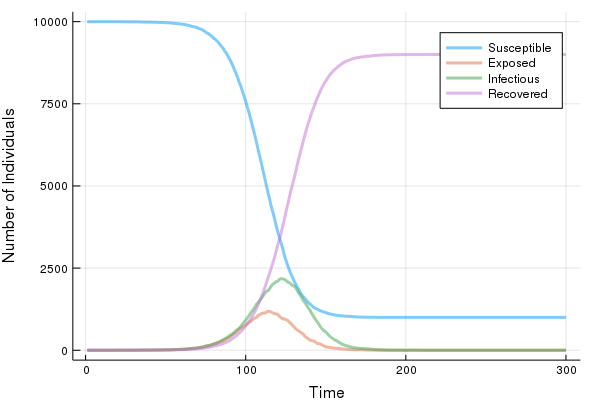

In [10]:
gr(fmt = :png)
plot( sim[:, :time],
       [sim[:, :S], sim[:, :E], sim[:, :I], sim[:, :R]],
       label = ["Susceptible", "Exposed", "Infectious", "Recovered"],
       xlabel = "Time", ylabel = "Number of Individuals",
       linealpha = 0.5, linewidth = 3 )

In [13]:
using Random
Random.seed!(12345)
test_sim = seir_simulation( Dict("S" => 9999, "E" => 1, "I" => 0, "R" => 0),
                            Dict("k_E" =>  5, "gamma_E" => 1.0,
                                 "k_I" => 10, "gamma_I" => 1.0,
                                 "beta" => 0.25),
                            100 )
test_result = convert(Matrix, test_sim[end-2 : end, :])

correct_result = [ 6416  1017  1298  1269   98 ;
                   6210  1045  1379  1366   99 ;
                   6010  1086  1442  1462  100 ]

println("\n-------------------")
if correct_result == test_result
    println("    Test PASSED")    
else
    println("    Test FAILED")    
end
println("-------------------\n")


-------------------
    Test PASSED
-------------------

